In [1]:
# Import libraries
import os
import sys

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Set up paths
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_folder = os.path.join(project_root, 'src')

In [3]:
# Import src functions
sys.path.insert(0, src_folder)
from modeling import *
from stats_and_visualisations import *
from s3_storage import *

In [4]:
### ---- PARAMETERS
iterations_per_model = 3

In [5]:
# Import data
X_train = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_X_train.npy')
X_test = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_X_test.npy')
y_train = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_y_train.npy')
y_test = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_y_test.npy')
print('--> Importing done')

--> Importing done


## Logistic regression

In [6]:
# Create temporary training and validation sets
X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
# Define training function
def train_logistic(X_train, X_test, y_train, y_test):

    clf = LogisticRegression(random_state=0,
                             solver='lbfgs',
                             class_weight='balanced').fit(X_train, y_train)

    train_predict = clf.predict_proba(X_train)
    test_predict = clf.predict_proba(X_test)

    train_score = roc_auc_score(y_train, train_predict[:,1])
    test_score = roc_auc_score(y_test, test_predict[:,1])

    print('Logistic Train', train_score)
    print('Logistic Test', test_score)
    
    return train_score, test_score, clf

In [8]:
train_score, test_score, logistic_model = train_logistic(X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp)

Logistic Train 0.8475897768941401
Logistic Test 0.8307833607155896


In [9]:
# Save model as Pickle
to_s3(obj=logistic_model, bucket='mimic-jamesi', filepath='models/logistic_regression')

## Define functions

In [10]:
def run_random_search(model, random_grid, scoring, cv, n_iter, X_train, y_train):
    
    random_search_model = RandomizedSearchCV(estimator = model, scoring=scoring,
                                   param_distributions = random_grid,
                                   n_iter = n_iter, cv = cv, verbose=0,
                                   random_state=8, n_jobs = -1,
                                   return_train_score=True)

    # Fit the random search model
    random_search_model.fit(X_train, y_train)

    # Print the best CV score
    print('--> Best CV Score: ', random_search_model.best_score_)
    
    # Produce the final outputs
    cv_df = pd.DataFrame(random_search_model.cv_results_)
    cv_df.drop(columns=['mean_fit_time', 'mean_score_time', 'rank_test_score',
                        'split0_test_score', 'split0_train_score', 'split1_test_score',
                        'split1_train_score', 'split2_test_score', 'split2_train_score',
                        'split3_test_score', 'split3_train_score', 'split4_test_score',
                        'split4_train_score', 'std_fit_time', 'std_score_time',
                        'std_test_score', 'std_train_score'], inplace=True)
    cols = [c.replace('param_', '') for c in cv_df.columns]
    cv_df.columns = cols
    cv_df.rename(columns={'mean_train_score': 'training_score', 'mean_test_score': 'valid_score'}, inplace=True)
    cv_df.sort_values(by='valid_score', ascending=False, inplace=True)
    
    best_params = random_search_model.best_params_
    
    # Visualise best CV score by run
    best_cv_by_run(cv_df, 'valid_score')
    
    # Visualise the scores by single hyperparameters
    plot_single_results(cv_df, 'training_score', 'valid_score', 'params')
    
    return cv_df, best_params

## Decision tree

In [11]:
# define the grid search parameters
criterion = ['gini', 'entropy']
max_features = list(np.arange(2, X_train.shape[1]))
max_depth = list(np.arange(1, 100))
max_depth.append(None)
min_samples_split = list(np.arange(2, 250))
min_samples_leaf = list(np.arange(1, 250))

# Create the random grid
dt_random_grid = {'criterion': criterion,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

--> Best CV Score:  0.8456808366151576
[1, 2, 3]
[0.80576391 0.84011615 0.84568084]


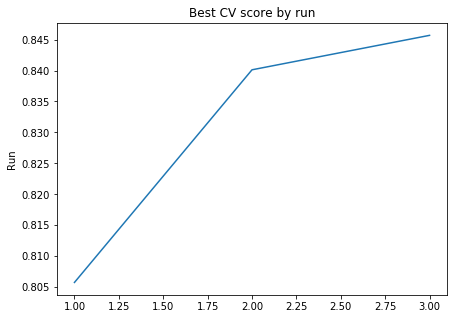

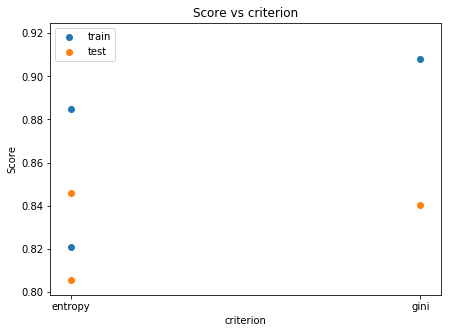

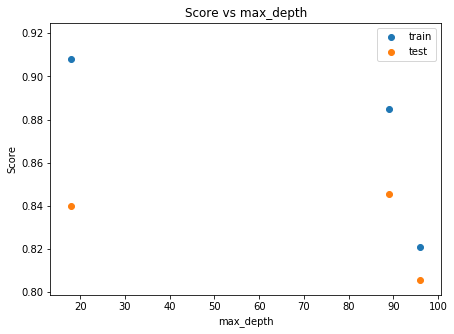

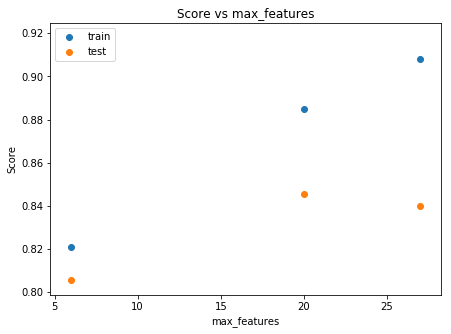

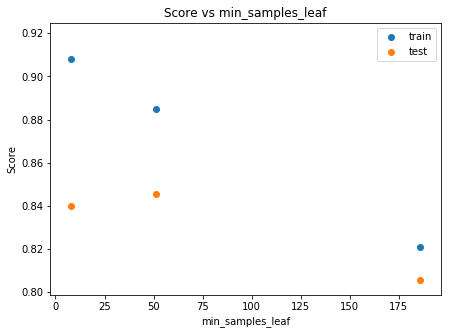

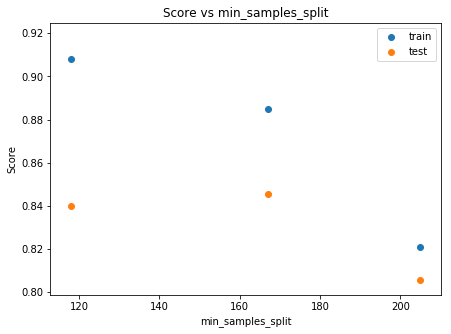

,valid_score,training_score,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,params
1,0.840116,0.907965,gini,18,27,8,118,"{'min_samples_split': 118, 'min_samples_leaf':..."
2,0.845681,0.885076,entropy,89,20,51,167,"{'min_samples_split': 167, 'min_samples_leaf':..."
0,0.805764,0.820881,entropy,96,6,186,205,"{'min_samples_split': 205, 'min_samples_leaf':..."


In [12]:
# Run the random search model
dt_random_search_results, dt_best_params = run_random_search(model=DecisionTreeClassifier(),
                                                             random_grid=dt_random_grid,
                                                             scoring='roc_auc', cv=5,
                                                             n_iter=iterations_per_model, 
                                                             X_train=X_train, y_train=y_train)
dt_random_search_results

In [ ]:
# Re-run on best parameters and save model
final_run(X_train, y_train,
          best_params=dt_best_params,
          classifier=DecisionTreeClassifier,
          model_name='decision_tree')

## Random Forest

In [ ]:
# define the grid search parameters
n_estimators = list(np.arange(20, 3000, 5))
max_features = list(np.arange(2, X_train.shape[1]))
max_depth = list(np.arange(1, 100))
max_depth.append(None)
min_samples_split = list(np.arange(2, 250))
min_samples_leaf = list(np.arange(1, 250))
bootstrap = [True, False]

# Create the random grid
rf_random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

In [ ]:
# Run the random search model
rf_random_search_results, rf_best_params = run_random_search(model=RandomForestClassifier(),
                                                            random_grid=rf_random_grid,
                                                            scoring='roc_auc', cv=5,
                                                            n_iter=iterations_per_model, 
                                                            X_train=X_train, y_train=y_train)
rf_random_search_results

In [ ]:
# Re-run on best parameters and save model
final_run(X_train, y_train,
          best_params=rf_best_params,
          classifier=RandomForestClassifier,
          model_name='random_forest')